In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, splprep, splev
from scipy.ndimage import gaussian_filter1d

# ==================== WAYPOINT GENERATORS ====================

def line_waypoints(n=5): 
    return [(i,0) for i in range(n)]

def square_waypoints(size=5): 
    return [(0,0),(0,size),(size,size),(size,0),(0,0)]

def triangle_waypoints(size=5):
    h=size*np.sqrt(3)/2
    return [(0,0),(size/2,h),(size,0),(0,0)]

def rhombus_waypoints(width=6,height=4): 
    return [(0,0),(width/2,height),(width,0),(width/2,-height),(0,0)]

def circle_waypoints(radius=5,points=20):
    return [(radius*np.cos(2*np.pi*i/points),radius*np.sin(2*np.pi*i/points)) for i in range(points+1)]

def figure8_waypoints(radius=5,points=40):
    t = np.linspace(0,2*np.pi,points+1)
    return [(radius*np.sin(ti),radius*np.sin(ti)*np.cos(ti)) for ti in t]

def s_curve_waypoints(width=10,height=5,points=30):
    t = np.linspace(0,np.pi,points)
    return [(width*(ti/np.pi),height*np.sin(ti)) for ti in t]

def spiral_waypoints(turns=3,points_per_turn=20,spacing=1):
    waypoints=[]
    for t in np.linspace(0,2*np.pi*turns,points_per_turn*turns):
        r=spacing*t/(2*np.pi)
        waypoints.append((r*np.cos(t),r*np.sin(t)))
    return waypoints

def zigzag_waypoints(width=8, height=4, num_zigs=4):
    waypoints = [(0,0)]
    for i in range(1, num_zigs+1):
        x = i * width / num_zigs
        y = height if i % 2 == 1 else 0
        waypoints.append((x, y))
    return waypoints

def star_waypoints(radius=5, points=5):
    waypoints = []
    outer_radius = radius
    inner_radius = radius * 0.4
    for i in range(points * 2):
        angle = i * np.pi / points - np.pi/2
        r = outer_radius if i % 2 == 0 else inner_radius
        waypoints.append((r*np.cos(angle), r*np.sin(angle)))
    waypoints.append(waypoints[0])
    return waypoints

def hexagon_waypoints(size=5):
    waypoints = []
    for i in range(7):
        angle = i * np.pi / 3
        waypoints.append((size*np.cos(angle), size*np.sin(angle)))
    return waypoints

def U_turn_waypoints(length=8, width=4):
    return [(0,0), (0,length), (width,length), (width,0)]

def slalom_waypoints(length=10, width=3, gates=5):
    waypoints = [(0,0)]
    for i in range(1, gates+1):
        x = i * length / gates
        y = width if i % 2 == 1 else -width
        waypoints.append((x, y))
    return waypoints

# Test paths
test_paths={
    "Line": line_waypoints(),
    "Square": square_waypoints(),
    "Triangle": triangle_waypoints(),
    "Rhombus": rhombus_waypoints(),
    "Circle": circle_waypoints(),
    "Figure-8": figure8_waypoints(),
    "S-Curve": s_curve_waypoints(),
    "Spiral": spiral_waypoints(),
    "Zigzag": zigzag_waypoints(),
    "Star": star_waypoints(),
    "Hexagon": hexagon_waypoints(),
    "U-Turn": U_turn_waypoints(),
    "Slalom": slalom_waypoints()
}

# ==================== 6 SMOOTHING ALGORITHMS ====================

# 1. Quadratic Bezier
def detect_corners(waypoints, angle_threshold_deg=150):
    waypoints = np.array(waypoints)
    corners = []
    for i in range(1,len(waypoints)-1):
        v1 = waypoints[i] - waypoints[i-1]
        v2 = waypoints[i+1] - waypoints[i]
        angle = np.arccos(np.clip(np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)),-1.0,1.0))
        if np.degrees(angle) < angle_threshold_deg:
            corners.append(i)
    return corners

def quadratic_bezier_exact(p0, p_corner, p2, num_points=10):
    p0, p_corner, p2 = np.array(p0), np.array(p_corner), np.array(p2)
    C = 2*p_corner - 0.5*(p0 + p2)
    t_vals = np.linspace(0,1,num_points)
    curve = [(1-t)**2*p0 + 2*(1-t)*t*C + t**2*p2 for t in t_vals]
    return np.array(curve)

def bezier_smooth(waypoints, angle_threshold_deg=150, fraction=0.2, num_points=10):
    waypoints = np.array(waypoints)
    smoothed_path = [waypoints[0]]
    corners = detect_corners(waypoints, angle_threshold_deg)
    i = 1
    while i < len(waypoints)-1:
        if i in corners:
            p_prev = waypoints[i-1] + fraction*(waypoints[i]-waypoints[i-1])
            p_next = waypoints[i+1] - fraction*(waypoints[i+1]-waypoints[i])
            bezier_pts = quadratic_bezier_exact(p_prev, waypoints[i], p_next, num_points=num_points)
            smoothed_path.extend(bezier_pts[1:-1])
            i += 1
        else:
            smoothed_path.append(waypoints[i])
            i += 1
    smoothed_path.append(waypoints[-1])
    return np.array(smoothed_path)

# 2. Cubic Spline
def cubic_spline_smooth(waypoints, num_points=150):
    waypoints = np.array(waypoints)
    if len(waypoints) < 2:
        return waypoints
    mask = np.ones(len(waypoints), dtype=bool)
    mask[1:] = ~np.all(waypoints[1:] == waypoints[:-1], axis=1)
    waypoints = waypoints[mask]
    if len(waypoints) < 2:
        return waypoints
    distances = np.sqrt(np.sum(np.diff(waypoints, axis=0)**2, axis=1))
    t = np.concatenate(([0], np.cumsum(distances)))
    if len(np.unique(t)) < 2:
        return waypoints
    cs_x = CubicSpline(t, waypoints[:, 0], bc_type='natural')
    cs_y = CubicSpline(t, waypoints[:, 1], bc_type='natural')
    t_smooth = np.linspace(t[0], t[-1], num_points)
    smooth_path = np.column_stack([cs_x(t_smooth), cs_y(t_smooth)])
    return smooth_path

# 3. B-Spline
def bspline_smooth(waypoints, num_points=150, smoothing_factor=2):
    waypoints = np.array(waypoints)
    if len(waypoints) < 4:
        return waypoints
    mask = np.ones(len(waypoints), dtype=bool)
    mask[1:] = ~np.all(waypoints[1:] == waypoints[:-1], axis=1)
    waypoints = waypoints[mask]
    if len(waypoints) < 4:
        return waypoints
    tck, u = splprep([waypoints[:, 0], waypoints[:, 1]], s=smoothing_factor, k=min(3, len(waypoints)-1))
    u_smooth = np.linspace(0, 1, num_points)
    smooth_path = np.column_stack(splev(u_smooth, tck))
    return smooth_path

# 4. Catmull-Rom Spline
def catmull_rom_smooth(waypoints, num_points=150, alpha=0.5):
    waypoints = np.array(waypoints)
    if len(waypoints) < 2:
        return waypoints
    mask = np.ones(len(waypoints), dtype=bool)
    mask[1:] = ~np.all(waypoints[1:] == waypoints[:-1], axis=1)
    waypoints = waypoints[mask]
    if len(waypoints) < 2:
        return waypoints
    
    def catmull_rom_segment(p0, p1, p2, p3, num_seg_points, alpha):
        def tj(ti, pi, pj):
            xi, yi = pi
            xj, yj = pj
            return ti + ((xj - xi)**2 + (yj - yi)**2)**(alpha/2)
        t0 = 0
        t1 = tj(t0, p0, p1)
        t2 = tj(t1, p1, p2)
        t3 = tj(t2, p2, p3)
        if t1 == t0 or t2 == t1 or t3 == t2:
            t = np.linspace(0, 1, num_seg_points)
            return p1 + t[:, None] * (p2 - p1)
        t = np.linspace(t1, t2, num_seg_points)
        A1 = (t1 - t)[:, None] / (t1 - t0) * p0 + (t - t0)[:, None] / (t1 - t0) * p1
        A2 = (t2 - t)[:, None] / (t2 - t1) * p1 + (t - t1)[:, None] / (t2 - t1) * p2
        A3 = (t3 - t)[:, None] / (t3 - t2) * p2 + (t - t2)[:, None] / (t3 - t2) * p3
        B1 = (t2 - t)[:, None] / (t2 - t0) * A1 + (t - t0)[:, None] / (t2 - t0) * A2
        B2 = (t3 - t)[:, None] / (t3 - t1) * A2 + (t - t1)[:, None] / (t3 - t1) * A3
        C = (t2 - t)[:, None] / (t2 - t1) * B1 + (t - t1)[:, None] / (t2 - t1) * B2
        return C
    
    p_start = 2 * waypoints[0] - waypoints[1]
    p_end = 2 * waypoints[-1] - waypoints[-2]
    extended_waypoints = np.vstack([p_start, waypoints, p_end])
    smooth_path = []
    num_segments = len(waypoints) - 1
    points_per_segment = max(num_points // num_segments, 2)
    for i in range(len(waypoints) - 1):
        segment = catmull_rom_segment(
            extended_waypoints[i], extended_waypoints[i + 1],
            extended_waypoints[i + 2], extended_waypoints[i + 3],
            points_per_segment, alpha)
        smooth_path.append(segment)
    smooth_path = np.vstack(smooth_path)
    return smooth_path

# 5. Minimum Jerk
def minimum_jerk_smooth(waypoints, num_points=150):
    waypoints = np.array(waypoints)
    if len(waypoints) < 2:
        return waypoints
    smooth_path = []
    num_segments = len(waypoints) - 1
    points_per_segment = num_points // num_segments
    for i in range(num_segments):
        p_start = waypoints[i]
        p_end = waypoints[i + 1]
        t = np.linspace(0, 1, points_per_segment)
        s = 10 * t**3 - 15 * t**4 + 6 * t**5
        segment = p_start + s[:, None] * (p_end - p_start)
        smooth_path.append(segment)
    smooth_path = np.vstack(smooth_path)
    return smooth_path

# 6. Gaussian Smoothing
def gaussian_smooth(waypoints, num_points=150, sigma=3):
    waypoints = np.array(waypoints)
    if len(waypoints) < 3:
        return waypoints
    distances = np.sqrt(np.sum(np.diff(waypoints, axis=0)**2, axis=1))
    t = np.concatenate(([0], np.cumsum(distances)))
    t_interp = np.linspace(0, t[-1], num_points)
    x_interp = np.interp(t_interp, t, waypoints[:, 0])
    y_interp = np.interp(t_interp, t, waypoints[:, 1])
    x_smooth = gaussian_filter1d(x_interp, sigma=sigma)
    y_smooth = gaussian_filter1d(y_interp, sigma=sigma)
    return np.column_stack([x_smooth, y_smooth])

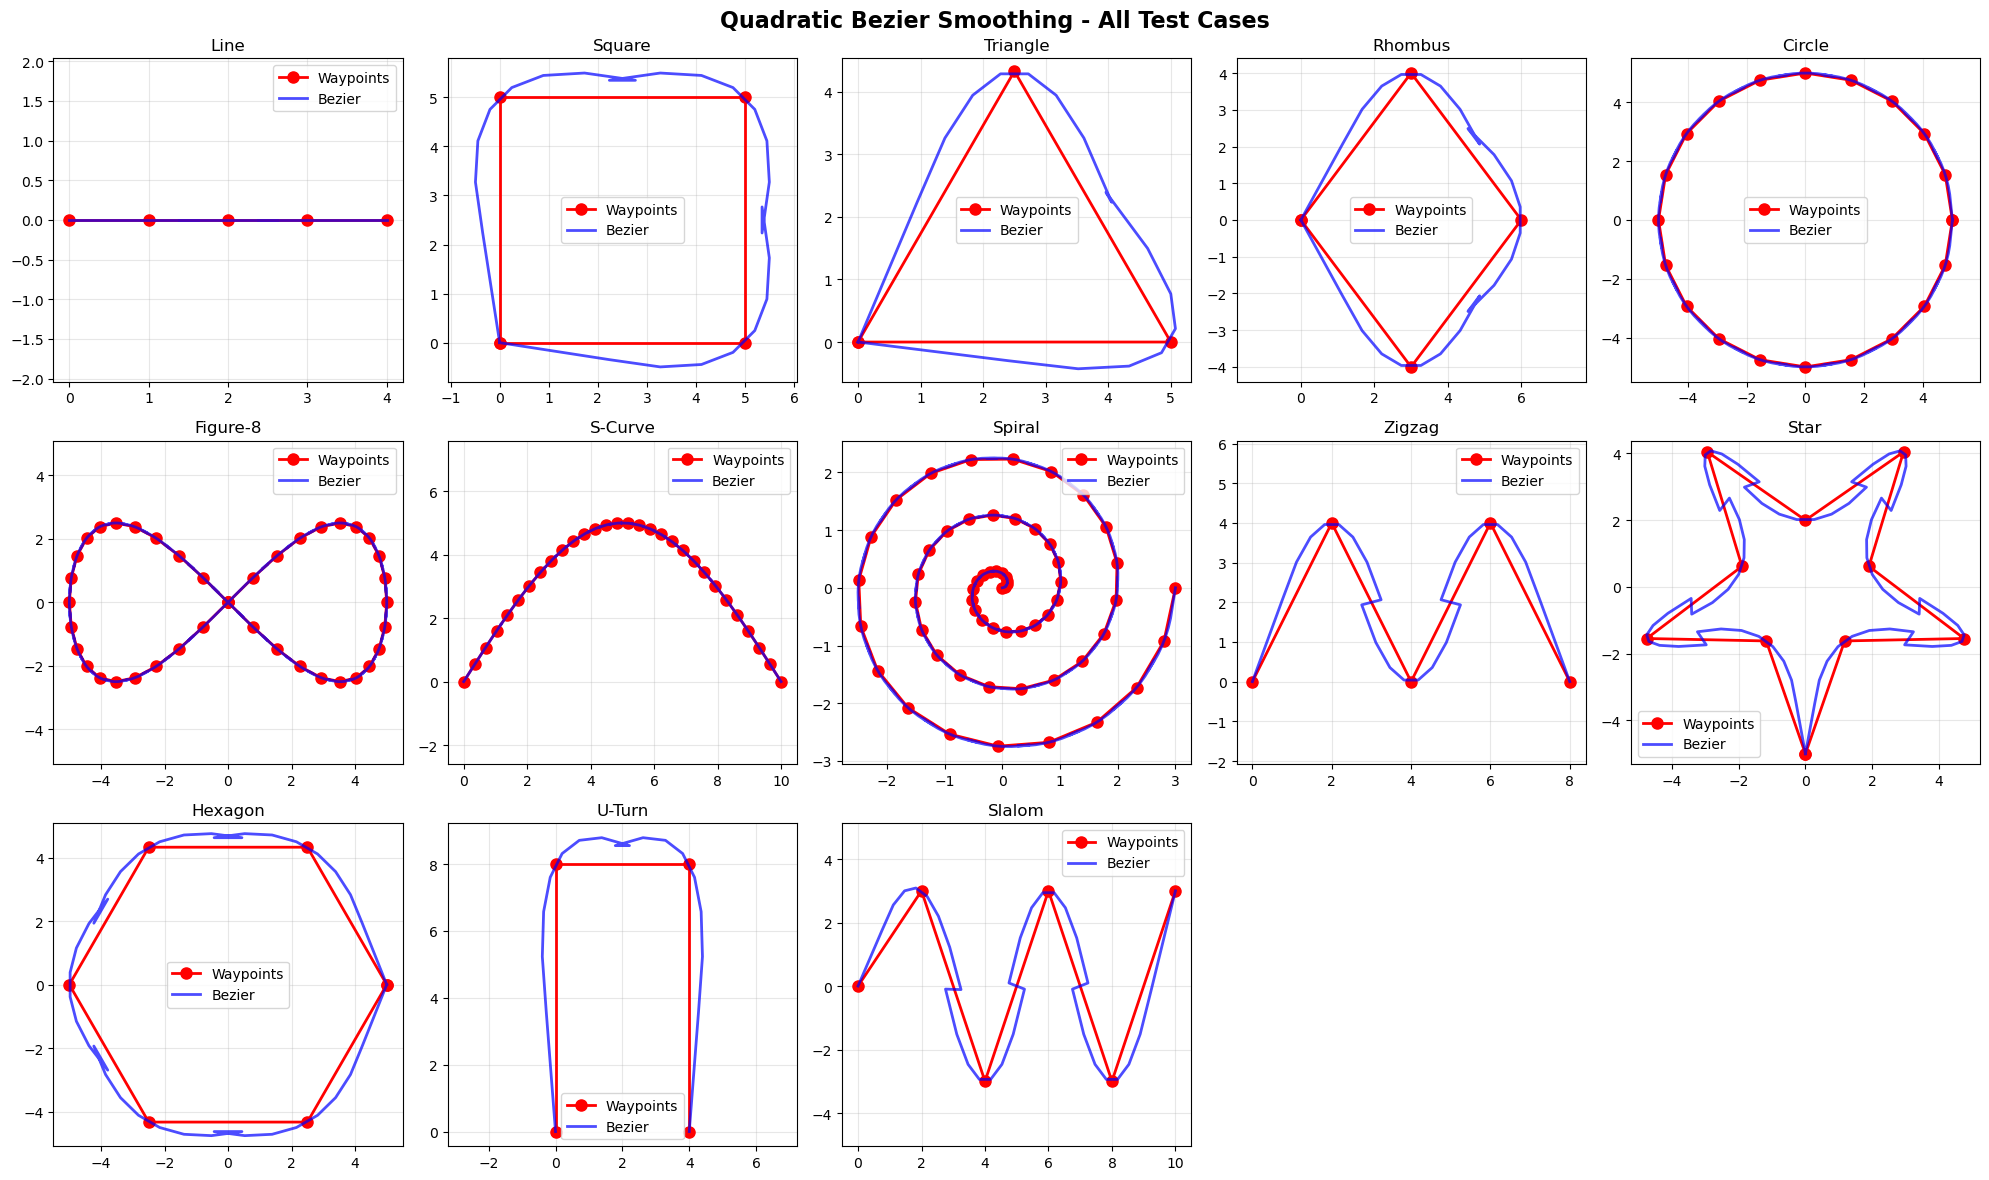

In [15]:
# Quadratic Bezier - All Test Cases
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, waypoints) in enumerate(test_paths.items()):
    ax = axes[idx]
    waypoints = np.array(waypoints)
    smoothed = bezier_smooth(waypoints, angle_threshold_deg=150, fraction=0.2, num_points=10)
    
    ax.plot(waypoints[:, 0], waypoints[:, 1], 'ro-', label='Waypoints', linewidth=2, markersize=8)
    ax.plot(smoothed[:, 0], smoothed[:, 1], 'b-', label='Bezier', linewidth=2, alpha=0.7)
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

for idx in range(len(test_paths), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Quadratic Bezier Smoothing - All Test Cases', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

it works fine, but in some places it has sharp corners which we don't need.

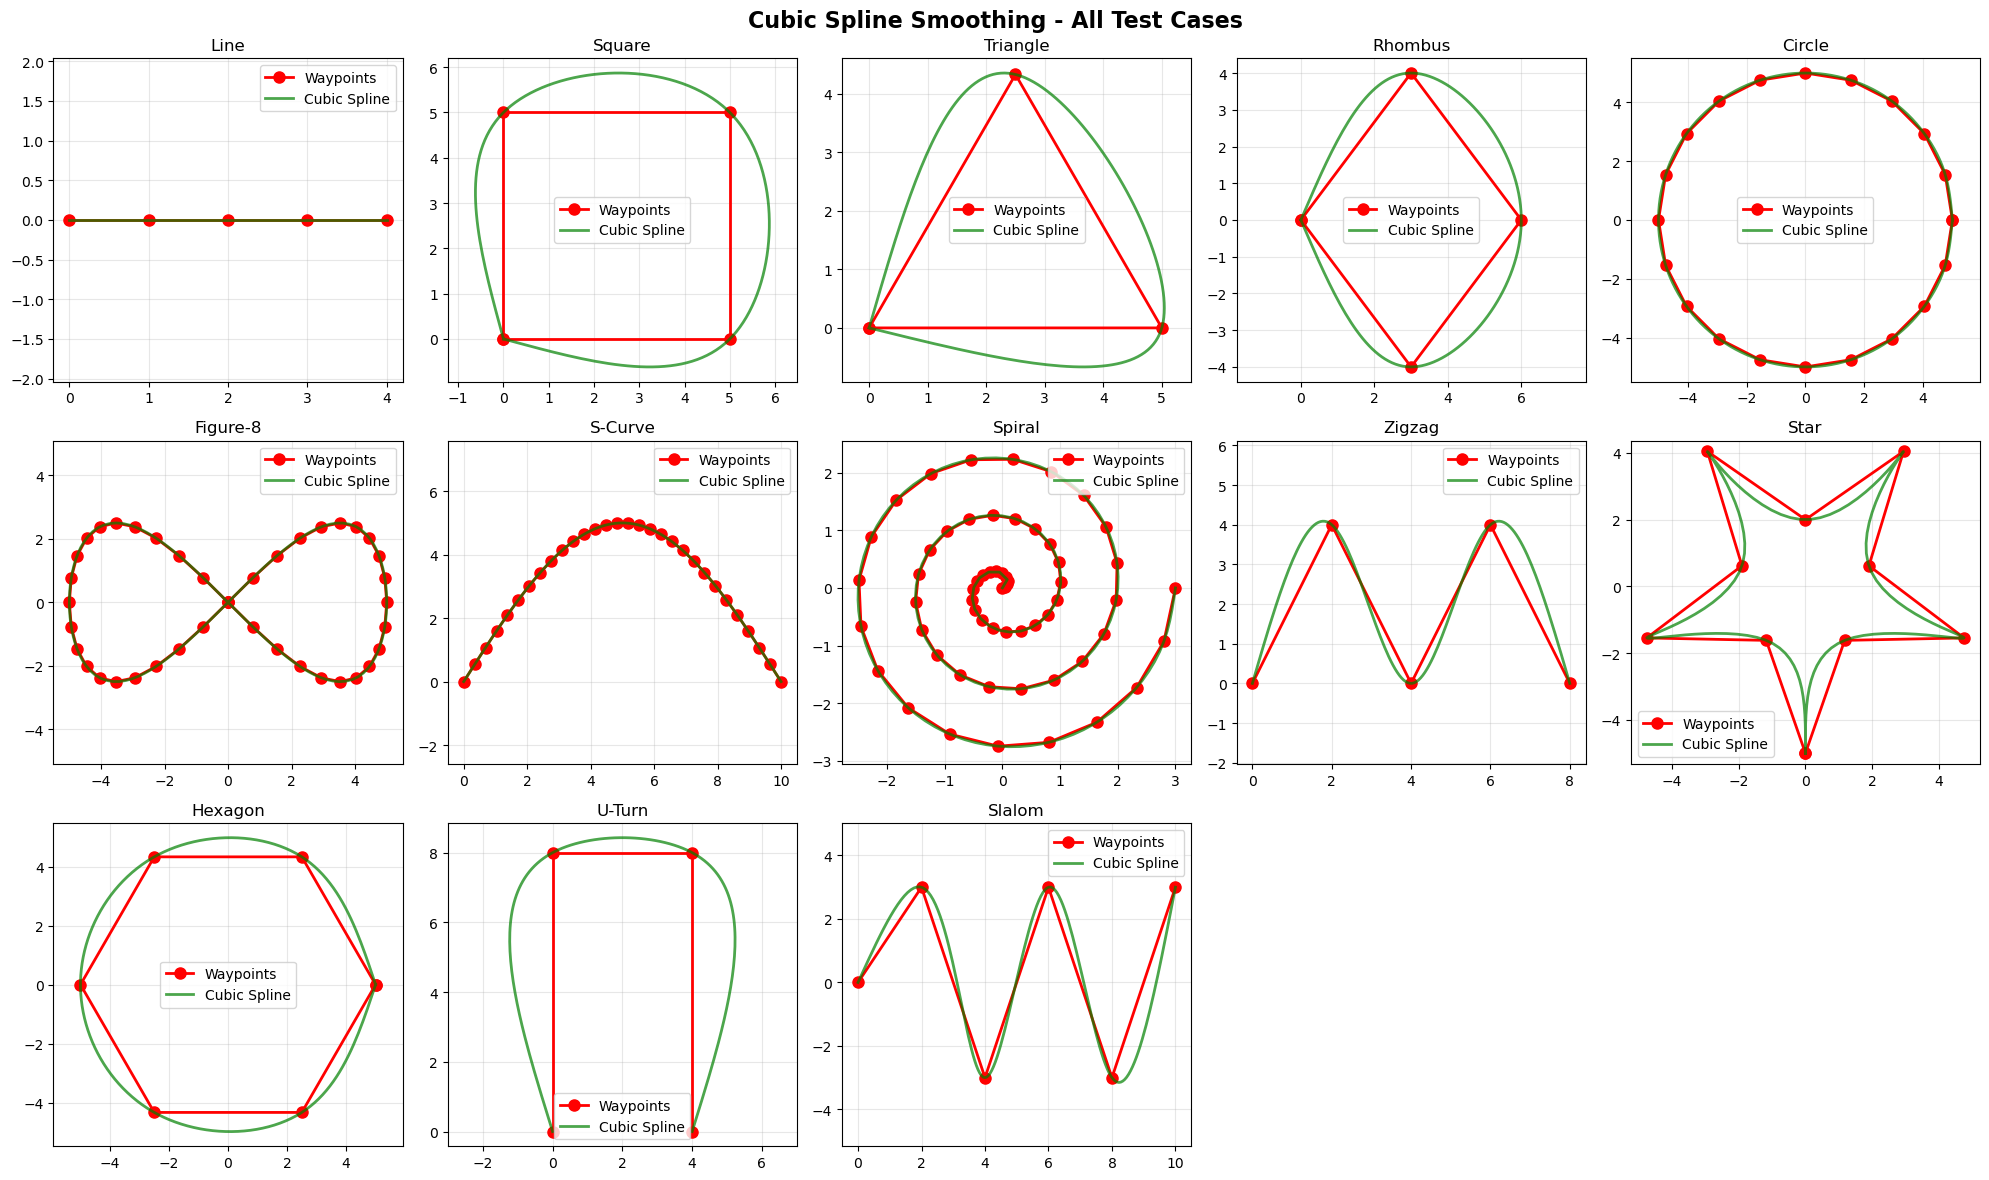

In [16]:
# Cubic Spline - All Test Cases
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, waypoints) in enumerate(test_paths.items()):
    ax = axes[idx]
    waypoints = np.array(waypoints)
    smoothed = cubic_spline_smooth(waypoints, num_points=150)
    
    ax.plot(waypoints[:, 0], waypoints[:, 1], 'ro-', label='Waypoints', linewidth=2, markersize=8)
    ax.plot(smoothed[:, 0], smoothed[:, 1], 'g-', label='Cubic Spline', linewidth=2, alpha=0.7)
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

for idx in range(len(test_paths), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Cubic Spline Smoothing - All Test Cases', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

it works fine for all the test cases above, can consider it.

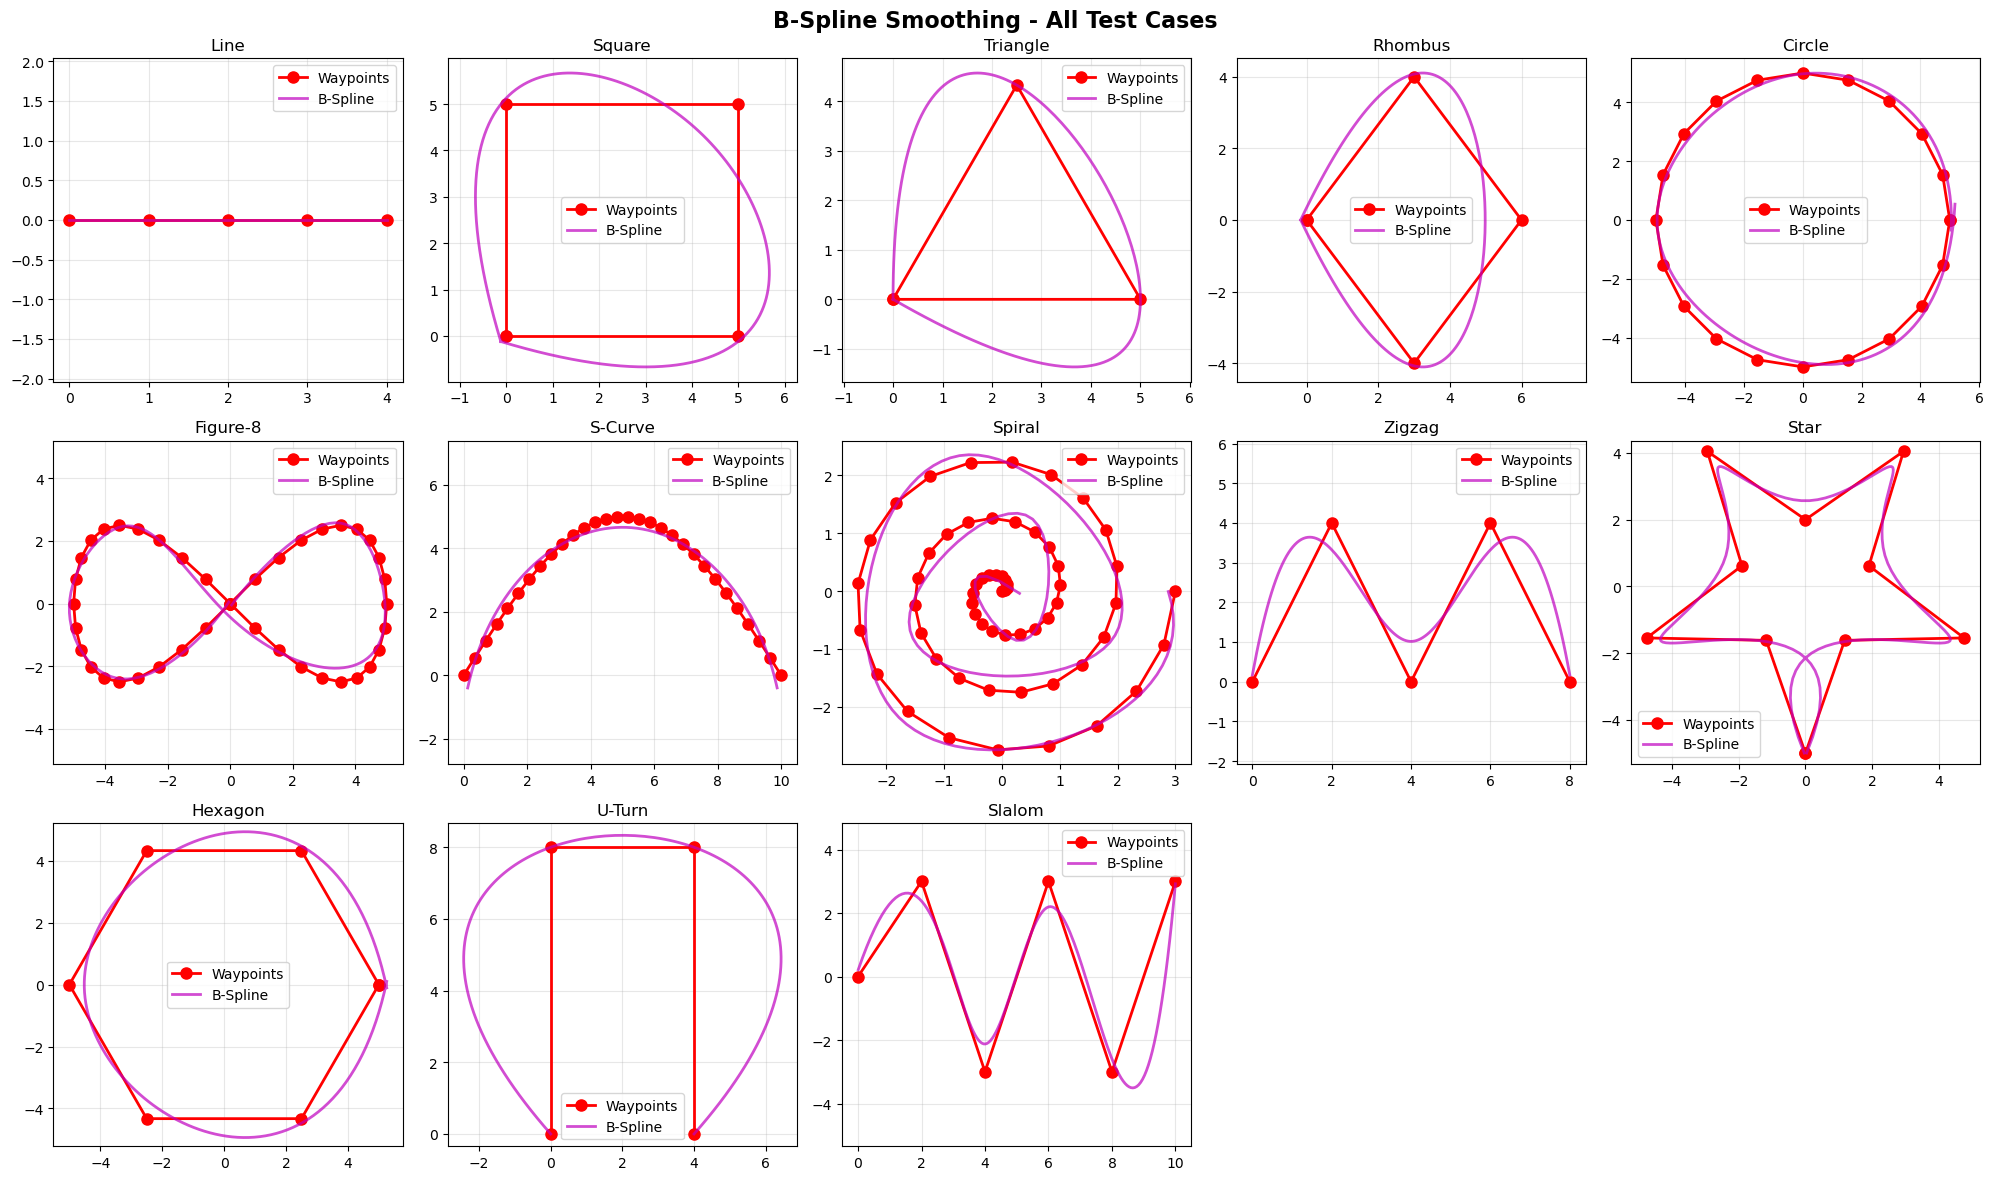

In [17]:
# B-Spline - All Test Cases
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, waypoints) in enumerate(test_paths.items()):
    ax = axes[idx]
    waypoints = np.array(waypoints)
    smoothed = bspline_smooth(waypoints, num_points=150, smoothing_factor=2)
    
    ax.plot(waypoints[:, 0], waypoints[:, 1], 'ro-', label='Waypoints', linewidth=2, markersize=8)
    ax.plot(smoothed[:, 0], smoothed[:, 1], 'm-', label='B-Spline', linewidth=2, alpha=0.7)
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

for idx in range(len(test_paths), len(axes)):
    axes[idx].axis('off')

plt.suptitle('B-Spline Smoothing - All Test Cases', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

this one ignore some waypoint itself, which is denies the whole point

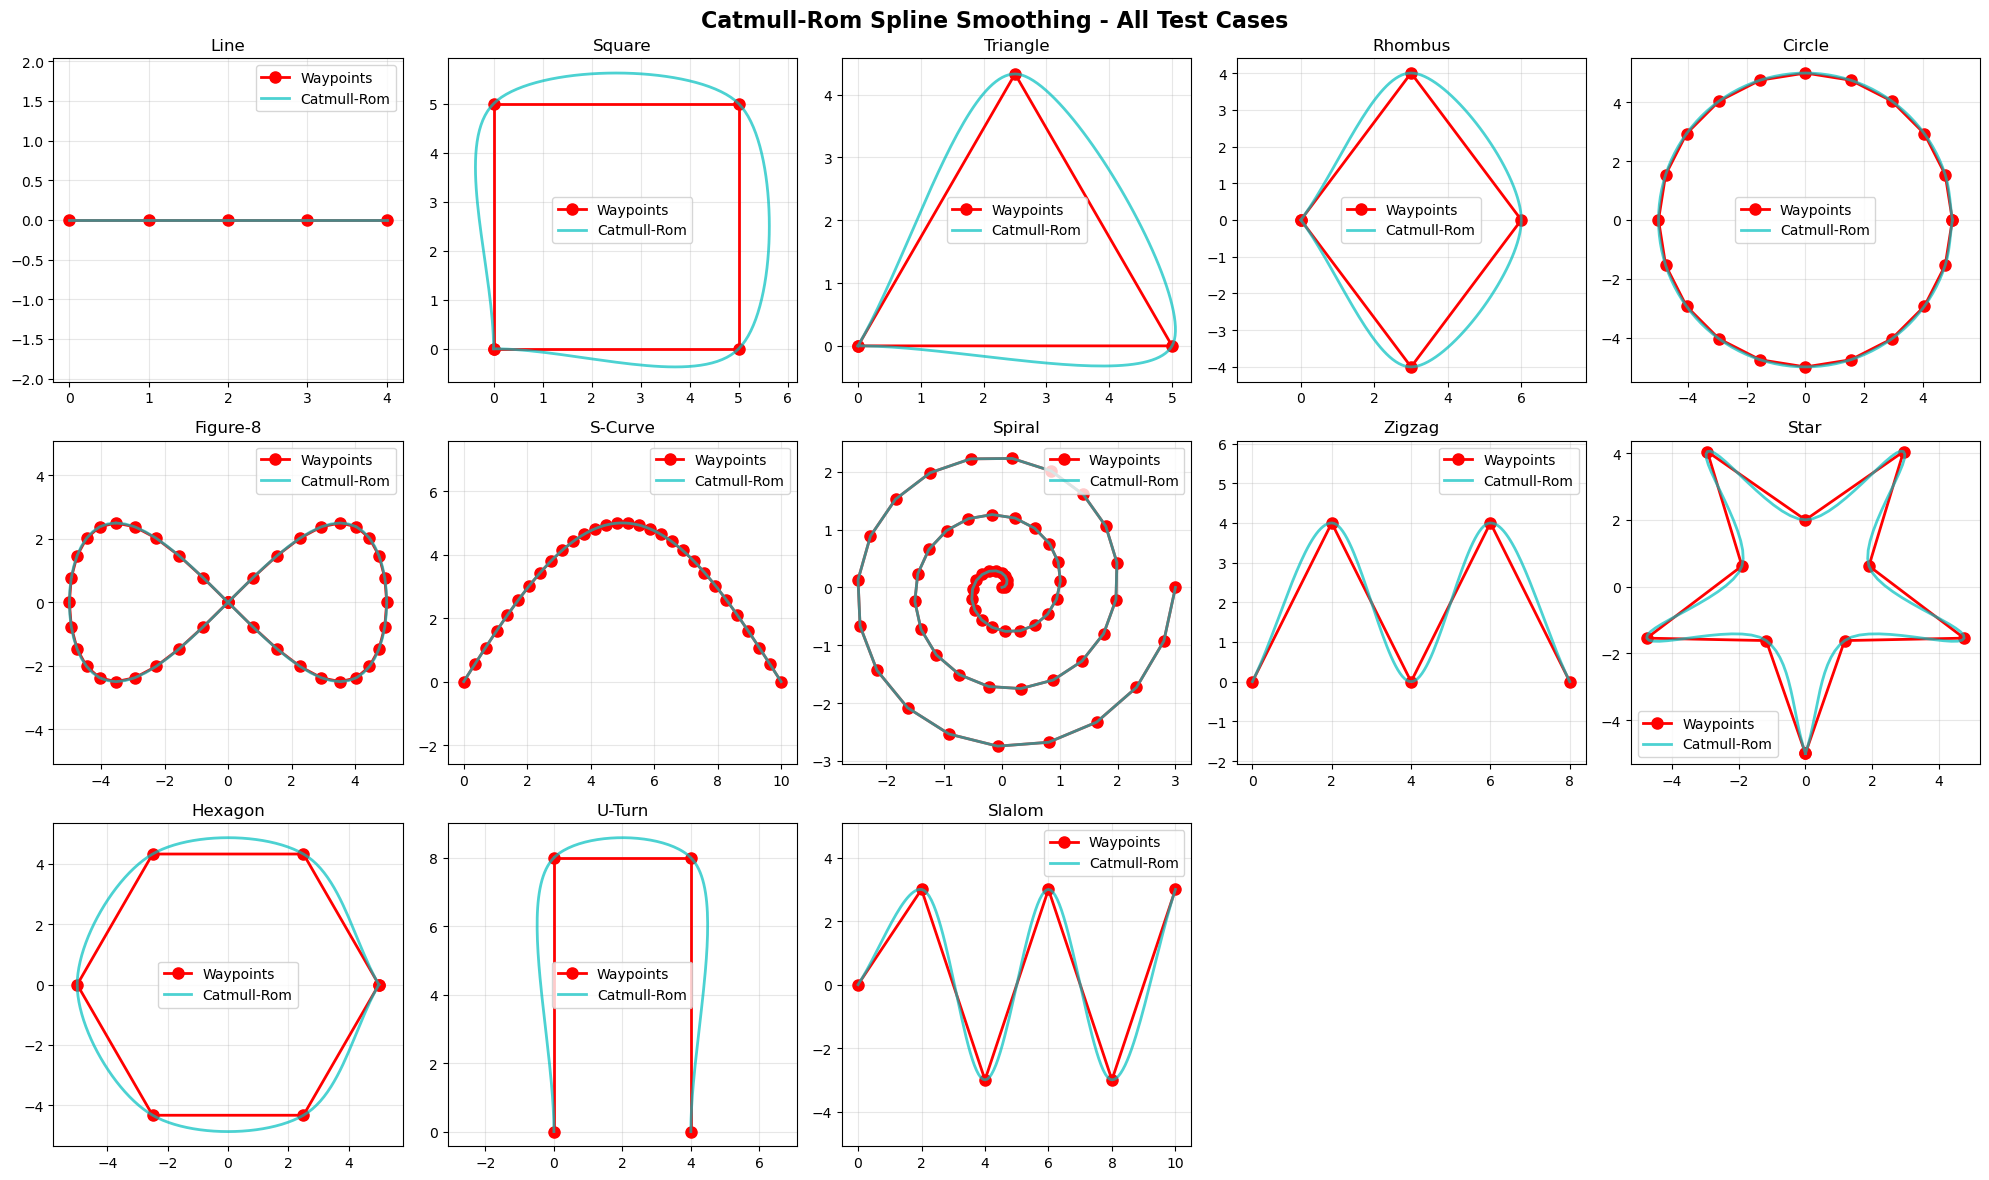

In [18]:
# Catmull-Rom Spline - All Test Cases
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, waypoints) in enumerate(test_paths.items()):
    ax = axes[idx]
    waypoints = np.array(waypoints)
    smoothed = catmull_rom_smooth(waypoints, num_points=150, alpha=0.5)
    
    ax.plot(waypoints[:, 0], waypoints[:, 1], 'ro-', label='Waypoints', linewidth=2, markersize=8)
    ax.plot(smoothed[:, 0], smoothed[:, 1], 'c-', label='Catmull-Rom', linewidth=2, alpha=0.7)
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

for idx in range(len(test_paths), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Catmull-Rom Spline Smoothing - All Test Cases', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

it works fine for all the test cases above, can consider it.

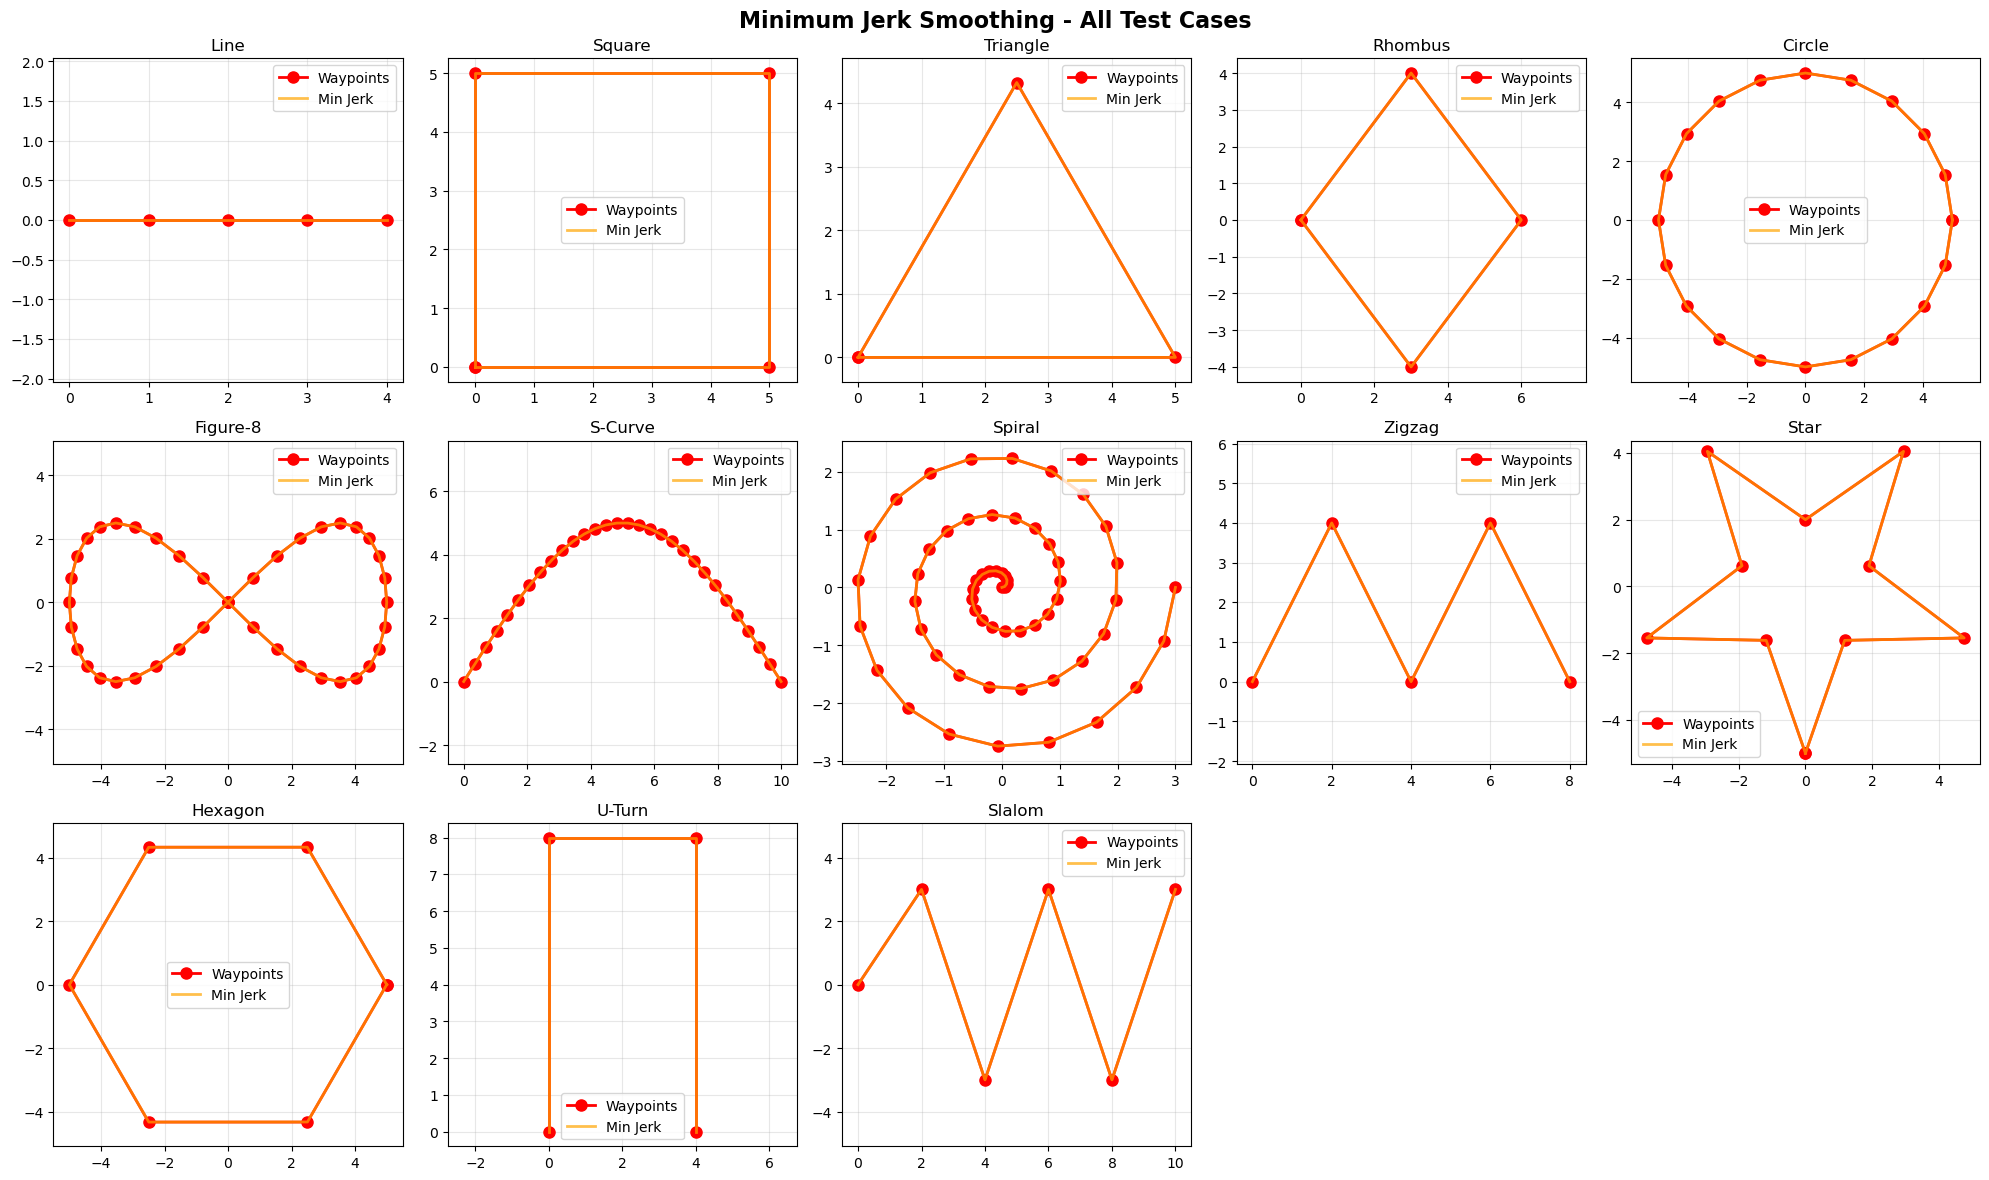

In [19]:
# Minimum Jerk - All Test Cases
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, waypoints) in enumerate(test_paths.items()):
    ax = axes[idx]
    waypoints = np.array(waypoints)
    smoothed = minimum_jerk_smooth(waypoints, num_points=150)
    
    ax.plot(waypoints[:, 0], waypoints[:, 1], 'ro-', label='Waypoints', linewidth=2, markersize=8)
    ax.plot(smoothed[:, 0], smoothed[:, 1], 'orange', label='Min Jerk', linewidth=2, alpha=0.7)
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

for idx in range(len(test_paths), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Minimum Jerk Smoothing - All Test Cases', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

this one does'nt produce smooth curves at all.

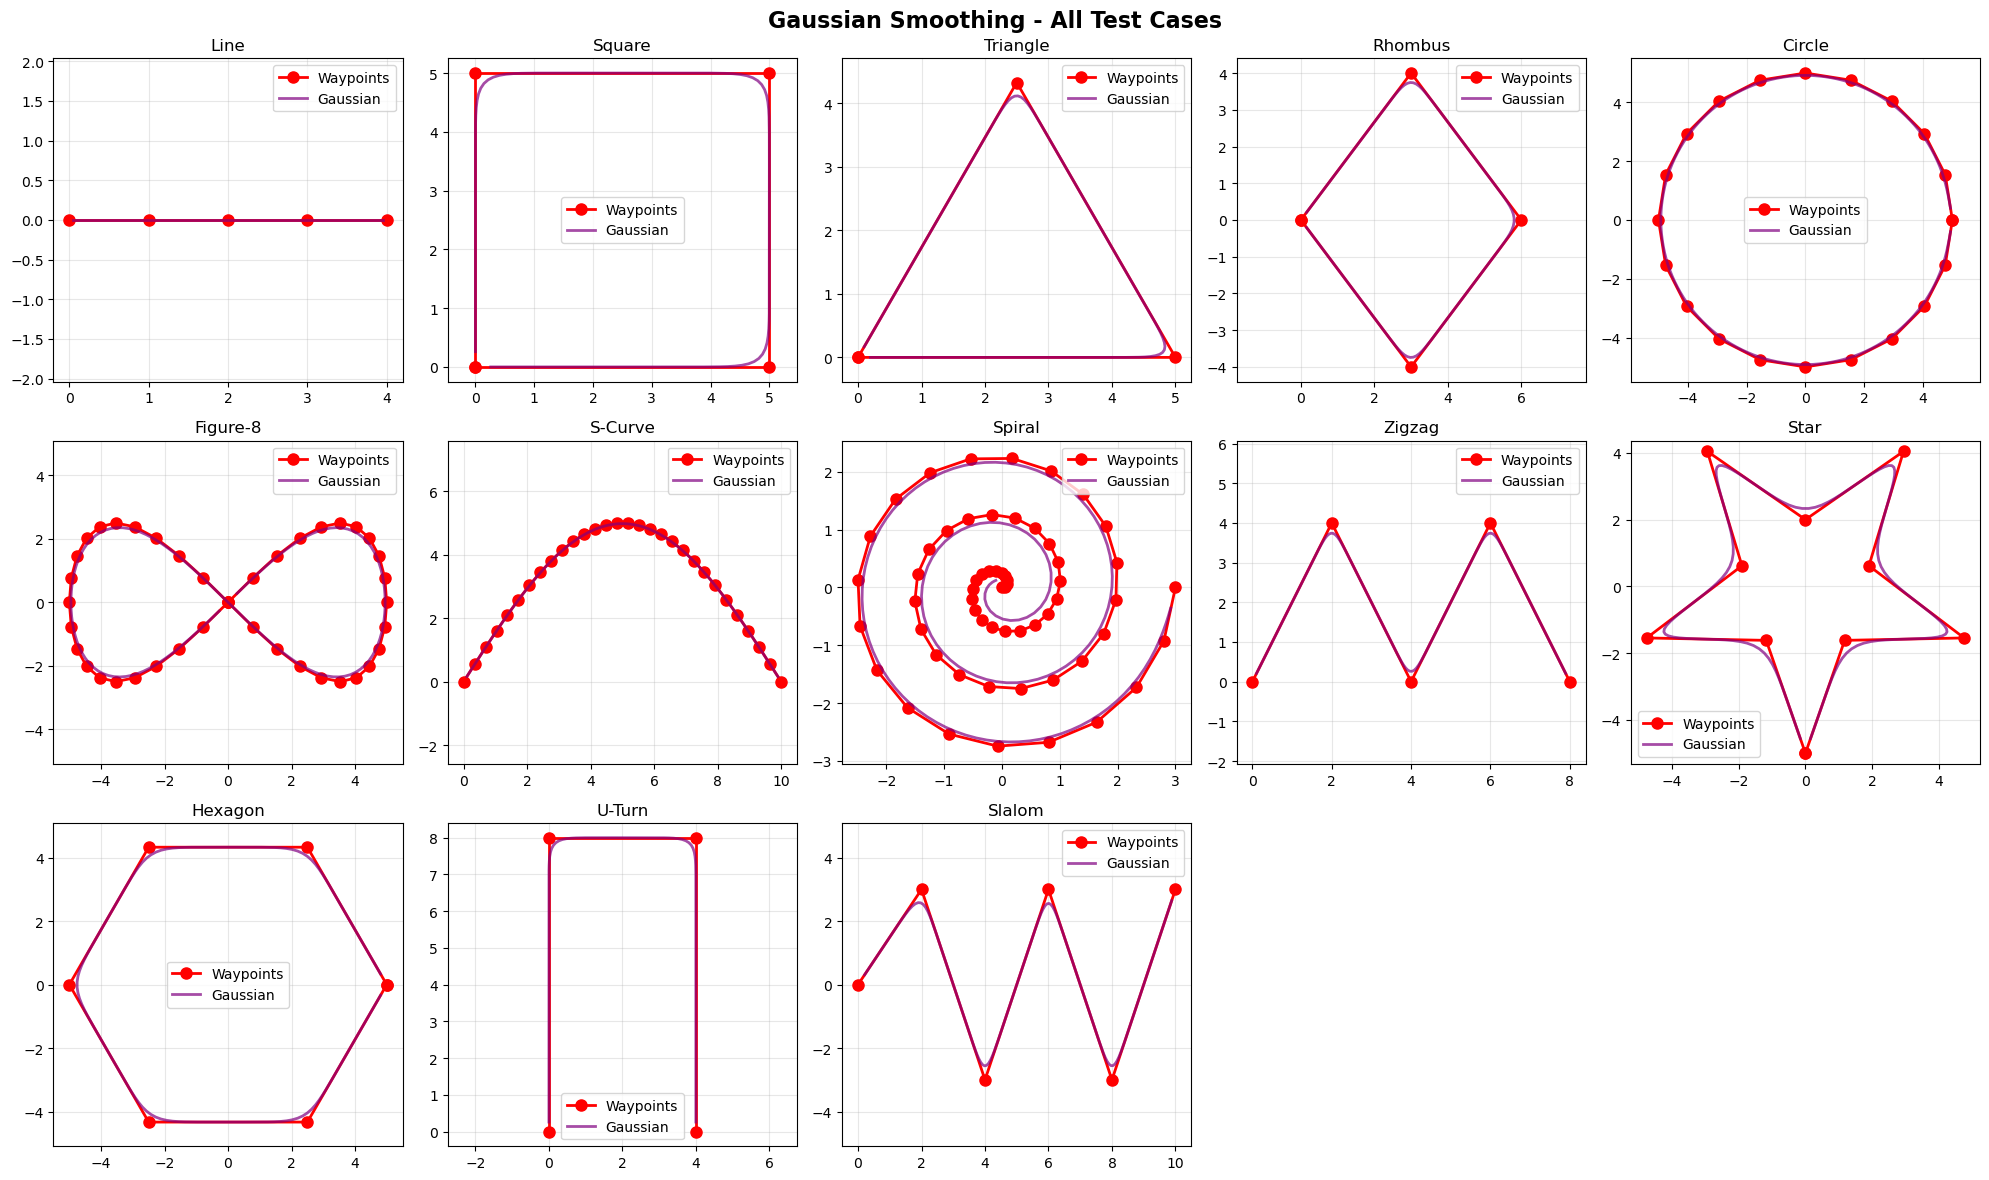

In [20]:
# Gaussian Smoothing - All Test Cases
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, waypoints) in enumerate(test_paths.items()):
    ax = axes[idx]
    waypoints = np.array(waypoints)
    smoothed = gaussian_smooth(waypoints, num_points=150, sigma=3)
    
    ax.plot(waypoints[:, 0], waypoints[:, 1], 'ro-', label='Waypoints', linewidth=2, markersize=8)
    ax.plot(smoothed[:, 0], smoothed[:, 1], 'purple', label='Gaussian', linewidth=2, alpha=0.7)
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

for idx in range(len(test_paths), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Gaussian Smoothing - All Test Cases', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

this applies fillet on sharp corners, but does't goes through the waypoints

                    CATMULL-ROM vs CUBIC SPLINE COMPARISON

Generating visualizations for all test cases...


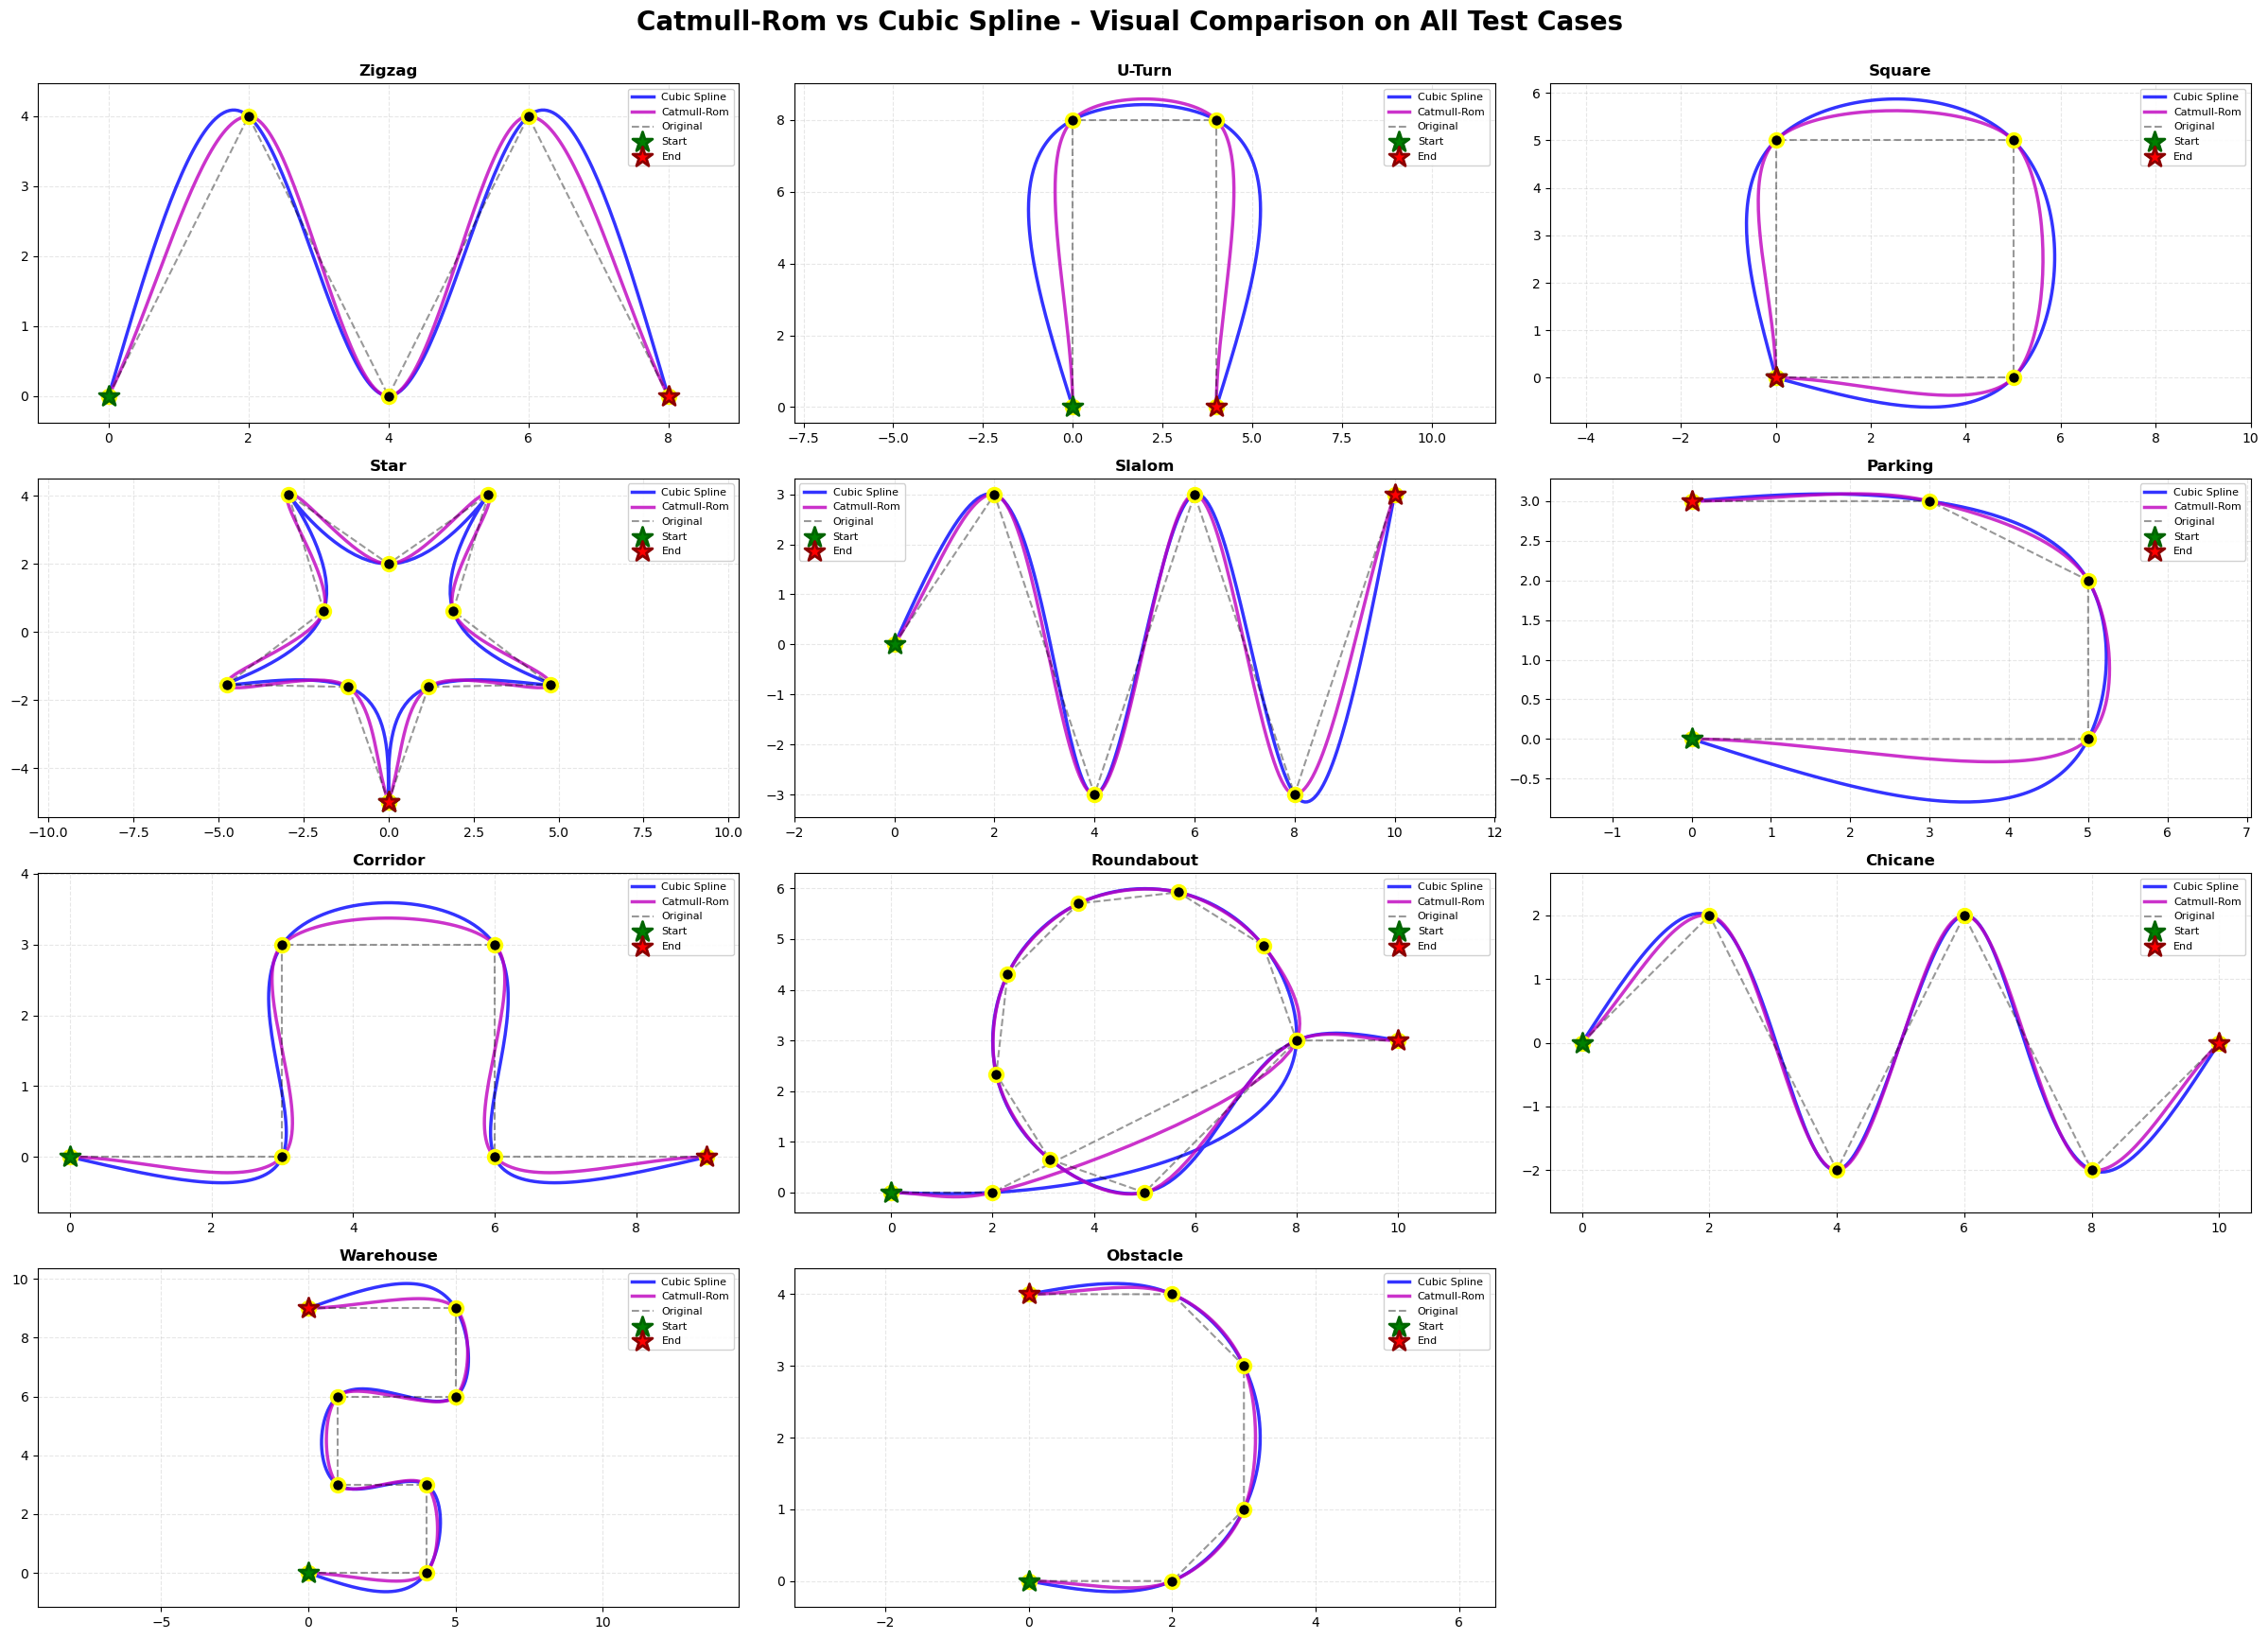

✅ Visualization complete!


In [21]:
# ================= BLOCK 1: ALGORITHMS & VISUALIZATIONS =================

from scipy.interpolate import CubicSpline, splprep, splev
import numpy as np
import matplotlib.pyplot as plt


# ==================== ALGORITHM IMPLEMENTATIONS ====================

def cubic_spline_interpolate(waypoints, num_points=200):
    """
    Cubic Spline Interpolation with Natural Boundary Conditions
    
    Properties:
    - Passes through ALL waypoints exactly
    - C2 continuous (smooth acceleration)
    - Natural boundary conditions (zero second derivative at endpoints)
    - Can overshoot on sharp turns
    
    Args:
        waypoints: List of (x,y) tuples
        num_points: Number of interpolated points
    
    Returns:
        Smooth path as numpy array
    """
    waypoints = np.array(waypoints)
    
    if len(waypoints) < 2:
        return waypoints
    
    # Remove duplicate consecutive points
    mask = np.ones(len(waypoints), dtype=bool)
    mask[1:] = ~np.all(waypoints[1:] == waypoints[:-1], axis=1)
    waypoints = waypoints[mask]
    
    if len(waypoints) < 2:
        return waypoints
    
    # Parameterize by cumulative chord length
    distances = np.sqrt(np.sum(np.diff(waypoints, axis=0)**2, axis=1))
    t = np.concatenate(([0], np.cumsum(distances)))
    
    if len(np.unique(t)) < 2:
        return waypoints
    
    # Create cubic splines for x and y coordinates
    cs_x = CubicSpline(t, waypoints[:, 0], bc_type='natural')
    cs_y = CubicSpline(t, waypoints[:, 1], bc_type='natural')
    
    # Generate smooth path
    t_smooth = np.linspace(t[0], t[-1], num_points)
    smooth_path = np.column_stack([cs_x(t_smooth), cs_y(t_smooth)])
    
    return smooth_path


def catmull_rom_interpolate(waypoints, num_points=200, alpha=0.5):
    """
    Catmull-Rom Spline with Centripetal Parameterization
    
    Properties:
    - Passes through ALL waypoints exactly
    - No overshooting on sharp turns
    - Centripetal (alpha=0.5) best for varied curvature
    - C1 continuous (smooth velocity)
    
    Args:
        waypoints: List of (x,y) tuples
        num_points: Number of interpolated points
        alpha: 0=uniform, 0.5=centripetal (recommended), 1.0=chordal
    
    Returns:
        Smooth path as numpy array
    """
    waypoints = np.array(waypoints)
    
    if len(waypoints) < 2:
        return waypoints
    
    # Remove duplicates
    mask = np.ones(len(waypoints), dtype=bool)
    mask[1:] = ~np.all(waypoints[1:] == waypoints[:-1], axis=1)
    waypoints = waypoints[mask]
    
    if len(waypoints) < 2:
        return waypoints
    
    def catmull_rom_segment(p0, p1, p2, p3, num_seg_points, alpha):
        """Generate Catmull-Rom curve segment"""
        def tj(ti, pi, pj):
            xi, yi = pi
            xj, yj = pj
            return ti + ((xj - xi)**2 + (yj - yi)**2)**(alpha/2)
        
        t0 = 0
        t1 = tj(t0, p0, p1)
        t2 = tj(t1, p1, p2)
        t3 = tj(t2, p2, p3)
        
        if t1 == t0 or t2 == t1 or t3 == t2:
            # Degenerate case - return linear interpolation
            t = np.linspace(0, 1, num_seg_points)
            return p1 + t[:, None] * (p2 - p1)
        
        t = np.linspace(t1, t2, num_seg_points)
        
        A1 = (t1 - t)[:, None] / (t1 - t0) * p0 + (t - t0)[:, None] / (t1 - t0) * p1
        A2 = (t2 - t)[:, None] / (t2 - t1) * p1 + (t - t1)[:, None] / (t2 - t1) * p2
        A3 = (t3 - t)[:, None] / (t3 - t2) * p2 + (t - t2)[:, None] / (t3 - t2) * p3
        
        B1 = (t2 - t)[:, None] / (t2 - t0) * A1 + (t - t0)[:, None] / (t2 - t0) * A2
        B2 = (t3 - t)[:, None] / (t3 - t1) * A2 + (t - t1)[:, None] / (t3 - t1) * A3
        
        C = (t2 - t)[:, None] / (t2 - t1) * B1 + (t - t1)[:, None] / (t2 - t1) * B2
        
        return C
    
    # Add virtual points at start and end for boundary conditions
    p_start = 2 * waypoints[0] - waypoints[1]
    p_end = 2 * waypoints[-1] - waypoints[-2]
    extended_waypoints = np.vstack([p_start, waypoints, p_end])
    
    smooth_path = []
    num_segments = len(waypoints) - 1
    points_per_segment = max(num_points // num_segments, 2)
    
    for i in range(len(waypoints) - 1):
        segment = catmull_rom_segment(
            extended_waypoints[i],
            extended_waypoints[i + 1],
            extended_waypoints[i + 2],
            extended_waypoints[i + 3],
            points_per_segment,
            alpha
        )
        smooth_path.append(segment)
    
    smooth_path = np.vstack(smooth_path)
    return smooth_path


# ==================== ADDITIONAL TEST CASES ====================

def parking_maneuver():
    """Parallel parking path"""
    return [(0,0), (5,0), (5,2), (3,3), (0,3)]

def narrow_corridor():
    """Narrow corridor with 90-degree turns"""
    return [(0,0), (3,0), (3,3), (6,3), (6,0), (9,0)]

def roundabout():
    """Circular roundabout entry/exit"""
    angles = np.linspace(0, 1.5*np.pi, 8)
    r = 3
    return [(0,0), (2,0)] + [(r*np.cos(a)+5, r*np.sin(a)+3) for a in angles] + [(8,3), (10,3)]

def chicane():
    """Racing chicane - alternating sharp turns"""
    return [(0,0), (2,2), (4,-2), (6,2), (8,-2), (10,0)]

def warehouse_path():
    """Warehouse navigation with tight corners"""
    return [(0,0), (4,0), (4,3), (1,3), (1,6), (5,6), (5,9), (0,9)]

def obstacle_avoidance():
    """S-shaped obstacle avoidance"""
    return [(0,0), (2,0), (3,1), (3,3), (2,4), (0,4)]

# Extended test suite
extended_test_paths = {
    # Original challenging cases
    "Zigzag": zigzag_waypoints(),
    "U-Turn": U_turn_waypoints(),
    "Square": square_waypoints(),
    "Star": star_waypoints(),
    "Slalom": slalom_waypoints(),
    # New real-world scenarios
    "Parking": parking_maneuver(),
    "Corridor": narrow_corridor(),
    "Roundabout": roundabout(),
    "Chicane": chicane(),
    "Warehouse": warehouse_path(),
    "Obstacle": obstacle_avoidance()
}

# ==================== VISUALIZATIONS ====================

print("="*80)
print(" "*20 + "CATMULL-ROM vs CUBIC SPLINE COMPARISON")
print("="*80)
print("\nGenerating visualizations for all test cases...")

fig = plt.figure(figsize=(24, 18))

for i, (name, waypoints) in enumerate(extended_test_paths.items()):
    try:
        # Apply both algorithms
        cubic_path = cubic_spline_interpolate(waypoints, num_points=200)
        catmull_path = catmull_rom_interpolate(waypoints, num_points=200, alpha=0.5)
        wp = np.array(waypoints)
        
        # Create subplot
        ax = plt.subplot(4, 3, i+1)
        
        # Plot smoothed paths
        ax.plot(cubic_path[:,0], cubic_path[:,1], 'b-', 
               label='Cubic Spline', linewidth=2.5, alpha=0.8)
        ax.plot(catmull_path[:,0], catmull_path[:,1], 'm-', 
               label='Catmull-Rom', linewidth=2.5, alpha=0.8)
        
        # Plot original waypoints
        ax.plot(wp[:,0], wp[:,1], 'k--', 
               label='Original', linewidth=1.5, alpha=0.4)
        ax.scatter(wp[:,0], wp[:,1], c='black', s=100, 
                  zorder=10, edgecolors='yellow', linewidths=2.5, marker='o')
        
        # Mark start and end
        ax.scatter(wp[0,0], wp[0,1], c='green', s=250, 
                  marker='*', zorder=11, edgecolors='darkgreen', linewidths=2, label='Start')
        ax.scatter(wp[-1,0], wp[-1,1], c='red', s=250, 
                  marker='*', zorder=11, edgecolors='darkred', linewidths=2, label='End')
        
        ax.set_title(f"{name}", fontsize=12, fontweight='bold')
        ax.axis('equal')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=8, loc='best', framealpha=0.9)
        
    except Exception as e:
        ax = plt.subplot(4, 3, i+1)
        ax.text(0.5, 0.5, f'Error: {str(e)}', 
               ha='center', va='center', transform=ax.transAxes, fontsize=9)
        ax.set_title(f"{name}", fontsize=12, fontweight='bold')

plt.suptitle("Catmull-Rom vs Cubic Spline - Visual Comparison on All Test Cases", 
            fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()

print("✅ Visualization complete!")


I feel that Catmull-Rom spline is gentler than cubic spline, but also lets verify it with some metrics

In [22]:
# ================= BLOCK 2: COMPREHENSIVE METRICS ANALYSIS =================

print("\n" + "="*80)
print(" "*25 + "METRICS COMPUTATION")
print("="*80)

def compute_path_metrics(original_waypoints, smoothed_path):
    """
    Compute comprehensive metrics for path quality assessment
    
    Returns dictionary with:
    - waypoint_deviation: How far smoothed path deviates from waypoints
    - max_curvature: Maximum curvature (tight turns)
    - mean_curvature: Average curvature
    - path_length: Total path length
    - smoothness: Measure of trajectory smoothness (lower = smoother)
    """
    original_waypoints = np.array(original_waypoints)
    smoothed_path = np.array(smoothed_path)
    
    metrics = {}
    
    # 1. Waypoint Coverage - Does it pass through waypoints?
    # Find closest point on smoothed path to each waypoint
    deviations = []
    for wp in original_waypoints:
        distances = np.sqrt(np.sum((smoothed_path - wp)**2, axis=1))
        min_dist = np.min(distances)
        deviations.append(min_dist)
    
    metrics['waypoint_deviation_max'] = np.max(deviations)
    metrics['waypoint_deviation_mean'] = np.mean(deviations)
    metrics['waypoint_deviation_std'] = np.std(deviations)
    metrics['passes_through_waypoints'] = metrics['waypoint_deviation_max'] < 0.1
    
    # 2. Curvature Analysis
    dx = np.gradient(smoothed_path[:, 0])
    dy = np.gradient(smoothed_path[:, 1])
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    curvature = np.nan_to_num(curvature, nan=0.0, posinf=0.0, neginf=0.0)
    
    metrics['max_curvature'] = np.max(curvature)
    metrics['mean_curvature'] = np.mean(curvature)
    metrics['curvature_std'] = np.std(curvature)
    
    # 3. Path Length
    segment_lengths = np.sqrt(np.sum(np.diff(smoothed_path, axis=0)**2, axis=1))
    metrics['path_length'] = np.sum(segment_lengths)
    
    # Original path length
    orig_lengths = np.sqrt(np.sum(np.diff(original_waypoints, axis=0)**2, axis=1))
    metrics['original_length'] = np.sum(orig_lengths)
    metrics['length_ratio'] = metrics['path_length'] / metrics['original_length']
    
    # 4. Smoothness (jerk - rate of change of acceleration)
    dddx = np.gradient(ddx)
    dddy = np.gradient(ddy)
    jerk = np.sqrt(dddx**2 + dddy**2)
    jerk = np.nan_to_num(jerk, nan=0.0, posinf=0.0, neginf=0.0)
    
    metrics['max_jerk'] = np.max(jerk)
    metrics['mean_jerk'] = np.mean(jerk)
    
    # 5. Velocity profile smoothness (assuming constant time steps)
    velocity = np.sqrt(dx**2 + dy**2)
    velocity_changes = np.abs(np.diff(velocity))
    metrics['velocity_variation'] = np.mean(velocity_changes)
    
    return metrics


# ==================== COMPUTE METRICS FOR ALL TEST CASES ====================

cubic_metrics_all = {}
catmull_metrics_all = {}

print("\nComputing metrics for all test cases...")
print("-" * 80)

for name, waypoints in extended_test_paths.items():
    try:
        # Generate paths
        cubic_path = cubic_spline_interpolate(waypoints, num_points=200)
        catmull_path = catmull_rom_interpolate(waypoints, num_points=200, alpha=0.5)
        
        # Compute metrics
        cubic_metrics_all[name] = compute_path_metrics(waypoints, cubic_path)
        catmull_metrics_all[name] = compute_path_metrics(waypoints, catmull_path)
        
        print(f"✓ {name:15s} - Metrics computed")
        
    except Exception as e:
        print(f"✗ {name:15s} - Error: {str(e)}")

print("-" * 80)
print(f"✅ Metrics computation complete for {len(cubic_metrics_all)} test cases\n")


# ==================== METRICS COMPARISON TABLE ====================

print("="*80)
print(" "*20 + "DETAILED METRICS COMPARISON TABLE")
print("="*80)
print()

# Header
print(f"{'Test Case':<15} {'Algorithm':<12} {'WP Dev':<10} {'Max Curv':<10} "
      f"{'Mean Curv':<10} {'Path Len':<10} {'Smoothness':<10}")
print("-" * 80)

for name in extended_test_paths.keys():
    if name in cubic_metrics_all and name in catmull_metrics_all:
        c_met = cubic_metrics_all[name]
        cr_met = catmull_metrics_all[name]
        
        # Cubic Spline row
        print(f"{name:<15} {'Cubic':<12} {c_met['waypoint_deviation_mean']:<10.4f} "
              f"{c_met['max_curvature']:<10.4f} {c_met['mean_curvature']:<10.4f} "
              f"{c_met['path_length']:<10.2f} {c_met['mean_jerk']:<10.4f}")
        
        # Catmull-Rom row
        print(f"{'':15} {'Catmull-Rom':<12} {cr_met['waypoint_deviation_mean']:<10.4f} "
              f"{cr_met['max_curvature']:<10.4f} {cr_met['mean_curvature']:<10.4f} "
              f"{cr_met['path_length']:<10.2f} {cr_met['mean_jerk']:<10.4f}")
        
        # Winner indication
        winner_curv = "Catmull-Rom" if cr_met['max_curvature'] < c_met['max_curvature'] else "Cubic"
        winner_smooth = "Catmull-Rom" if cr_met['mean_jerk'] < c_met['mean_jerk'] else "Cubic"
        print(f"{'':15} {'→ Better:':<12} {'Similar':<10} {winner_curv:<10} "
              f"{'Similar':<10} {'Similar':<10} {winner_smooth:<10}")
        print()

print("="*80)
print("\nLegend:")
print("  WP Dev    = Waypoint Deviation (lower = passes closer to waypoints)")
print("  Max Curv  = Maximum Curvature (lower = gentler turns)")
print("  Mean Curv = Average Curvature (lower = overall smoother)")
print("  Path Len  = Total path length")
print("  Smoothness= Mean Jerk (lower = smoother acceleration changes)")
print("="*80)


                         METRICS COMPUTATION

Computing metrics for all test cases...
--------------------------------------------------------------------------------
✓ Zigzag          - Metrics computed
✓ U-Turn          - Metrics computed
✓ Square          - Metrics computed
✓ Star            - Metrics computed
✓ Slalom          - Metrics computed
✓ Parking         - Metrics computed
✓ Corridor        - Metrics computed
✓ Roundabout      - Metrics computed
✓ Chicane         - Metrics computed
✓ Warehouse       - Metrics computed
✓ Obstacle        - Metrics computed
--------------------------------------------------------------------------------
✅ Metrics computation complete for 11 test cases

                    DETAILED METRICS COMPARISON TABLE

Test Case       Algorithm    WP Dev     Max Curv   Mean Curv  Path Len   Smoothness
--------------------------------------------------------------------------------
Zigzag          Cubic        0.0094     4.9189     0.7069     18.72      0


                         AGGREGATE STATISTICS

📊 CUBIC SPLINE - Aggregate Statistics:
--------------------------------------------------------------------------------
  Waypoint Deviation:  Mean=0.0159, Max=0.0272
  Maximum Curvature:   Mean=10.3831, Max=85.5890
  Average Curvature:   Mean=0.5609
  Path Length:         Mean=21.98
  Smoothness (Jerk):   Mean=0.0005

📊 CATMULL-ROM SPLINE - Aggregate Statistics:
--------------------------------------------------------------------------------
  Waypoint Deviation:  Mean=0.0000, Max=0.0000
  Maximum Curvature:   Mean=7.8470, Max=21.1204
  Average Curvature:   Mean=0.6796
  Path Length:         Mean=21.56
  Smoothness (Jerk):   Mean=0.0027



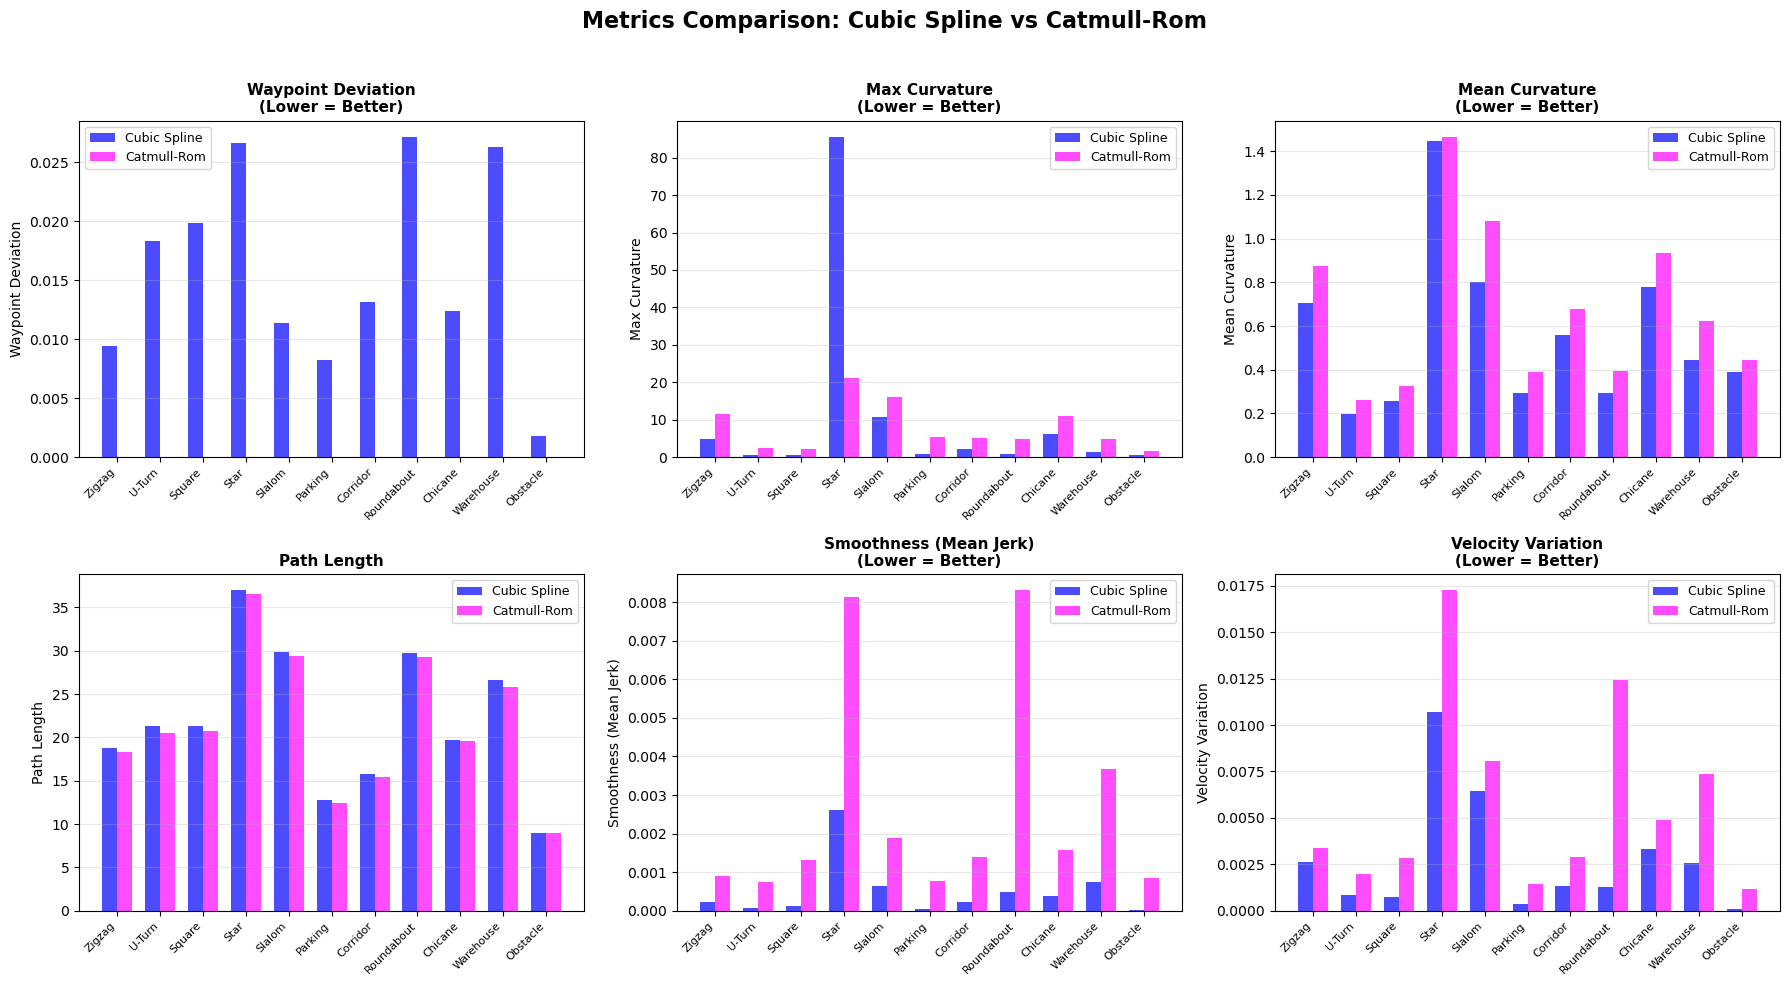


✅ Visual metrics comparison complete!


In [23]:
# ==================== AGGREGATE METRICS & VISUALIZATION ====================

print("\n" + "="*80)
print(" "*25 + "AGGREGATE STATISTICS")
print("="*80)

# Calculate aggregate statistics
def aggregate_metrics(metrics_dict):
    """Aggregate metrics across all test cases"""
    agg = {
        'waypoint_deviation_mean': [],
        'max_curvature': [],
        'mean_curvature': [],
        'path_length': [],
        'mean_jerk': [],
        'velocity_variation': []
    }
    
    for metrics in metrics_dict.values():
        for key in agg.keys():
            if key in metrics:
                agg[key].append(metrics[key])
    
    return {key: {'mean': np.mean(vals), 'std': np.std(vals), 'max': np.max(vals), 'min': np.min(vals)} 
            for key, vals in agg.items()}

cubic_agg = aggregate_metrics(cubic_metrics_all)
catmull_agg = aggregate_metrics(catmull_metrics_all)

print("\n📊 CUBIC SPLINE - Aggregate Statistics:")
print("-" * 80)
print(f"  Waypoint Deviation:  Mean={cubic_agg['waypoint_deviation_mean']['mean']:.4f}, "
      f"Max={cubic_agg['waypoint_deviation_mean']['max']:.4f}")
print(f"  Maximum Curvature:   Mean={cubic_agg['max_curvature']['mean']:.4f}, "
      f"Max={cubic_agg['max_curvature']['max']:.4f}")
print(f"  Average Curvature:   Mean={cubic_agg['mean_curvature']['mean']:.4f}")
print(f"  Path Length:         Mean={cubic_agg['path_length']['mean']:.2f}")
print(f"  Smoothness (Jerk):   Mean={cubic_agg['mean_jerk']['mean']:.4f}")

print("\n📊 CATMULL-ROM SPLINE - Aggregate Statistics:")
print("-" * 80)
print(f"  Waypoint Deviation:  Mean={catmull_agg['waypoint_deviation_mean']['mean']:.4f}, "
      f"Max={catmull_agg['waypoint_deviation_mean']['max']:.4f}")
print(f"  Maximum Curvature:   Mean={catmull_agg['max_curvature']['mean']:.4f}, "
      f"Max={catmull_agg['max_curvature']['max']:.4f}")
print(f"  Average Curvature:   Mean={catmull_agg['mean_curvature']['mean']:.4f}")
print(f"  Path Length:         Mean={catmull_agg['path_length']['mean']:.2f}")
print(f"  Smoothness (Jerk):   Mean={catmull_agg['mean_jerk']['mean']:.4f}")

print("\n" + "="*80)

# ==================== VISUAL METRICS COMPARISON ====================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

test_names = list(extended_test_paths.keys())
metrics_to_plot = [
    ('waypoint_deviation_mean', 'Waypoint Deviation\n(Lower = Better)', 0, 0),
    ('max_curvature', 'Max Curvature\n(Lower = Better)', 0, 1),
    ('mean_curvature', 'Mean Curvature\n(Lower = Better)', 0, 2),
    ('path_length', 'Path Length', 1, 0),
    ('mean_jerk', 'Smoothness (Mean Jerk)\n(Lower = Better)', 1, 1),
    ('velocity_variation', 'Velocity Variation\n(Lower = Better)', 1, 2)
]

for metric_key, title, row, col in metrics_to_plot:
    ax = axes[row, col]
    
    cubic_vals = [cubic_metrics_all[name][metric_key] for name in test_names 
                  if name in cubic_metrics_all]
    catmull_vals = [catmull_metrics_all[name][metric_key] for name in test_names 
                    if name in catmull_metrics_all]
    
    x = np.arange(len(test_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, cubic_vals, width, label='Cubic Spline', 
                   color='blue', alpha=0.7)
    bars2 = ax.bar(x + width/2, catmull_vals, width, label='Catmull-Rom', 
                   color='magenta', alpha=0.7)
    
    ax.set_ylabel(title.split('\n')[0], fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(test_names, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Metrics Comparison: Cubic Spline vs Catmull-Rom', 
            fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n✅ Visual metrics comparison complete!")

In [24]:
# ==================== FINAL VERDICT & RECOMMENDATIONS ====================

print("\n" + "="*80)
print(" "*25 + "🏆 FINAL VERDICT 🏆")
print("="*80)

# Check if required variables exist
if 'cubic_metrics_all' not in dir() or 'catmull_metrics_all' not in dir():
    print("\n⚠️  ERROR: Please run the previous cells to compute metrics first!")
    print("   Run cells 9 and 10 before running this cell.")
else:
    # Count wins in each category
    wins_cubic = 0
    wins_catmull = 0

    comparison_summary = []

    for name in extended_test_paths.keys():
        if name in cubic_metrics_all and name in catmull_metrics_all:
            c_met = cubic_metrics_all[name]
            cr_met = catmull_metrics_all[name]
            
            # Compare key metrics (lower is better for all)
            if cr_met['max_curvature'] < c_met['max_curvature']:
                wins_catmull += 1
            else:
                wins_cubic += 1

    print("\n📈 PERFORMANCE SUMMARY:")
    print("-" * 80)
    print(f"  Test cases with lower max curvature:")
    print(f"    • Cubic Spline:   {wins_cubic} cases")
    print(f"    • Catmull-Rom:    {wins_catmull} cases")

    # Determine overall winner
    print("\n🎯 KEY FINDINGS:")
    print("-" * 80)

    # Waypoint accuracy
    cubic_wp_dev = cubic_agg['waypoint_deviation_mean']['mean']
    catmull_wp_dev = catmull_agg['waypoint_deviation_mean']['mean']
    wp_winner = "Cubic Spline" if cubic_wp_dev < catmull_wp_dev else "Catmull-Rom"
    print(f"  1. Waypoint Accuracy: {wp_winner} ✓")
    print(f"     Cubic: {cubic_wp_dev:.6f}, Catmull-Rom: {catmull_wp_dev:.6f}")

    # Curvature
    cubic_curv = cubic_agg['max_curvature']['mean']
    catmull_curv = catmull_agg['max_curvature']['mean']
    curv_winner = "Catmull-Rom" if catmull_curv < cubic_curv else "Cubic Spline"
    print(f"\n  2. Lower Curvature (Smoother Turns): {curv_winner} ✓")
    print(f"     Cubic: {cubic_curv:.4f}, Catmull-Rom: {catmull_curv:.4f}")

    # Smoothness
    cubic_jerk = cubic_agg['mean_jerk']['mean']
    catmull_jerk = catmull_agg['mean_jerk']['mean']
    jerk_winner = "Catmull-Rom" if catmull_jerk < cubic_jerk else "Cubic Spline"
    print(f"\n  3. Smoothness (Lower Jerk): {jerk_winner} ✓")
    print(f"     Cubic: {cubic_jerk:.4f}, Catmull-Rom: {catmull_jerk:.4f}")

    # Path efficiency
    cubic_len = cubic_agg['path_length']['mean']
    catmull_len = catmull_agg['path_length']['mean']
    len_winner = "Cubic Spline" if cubic_len < catmull_len else "Catmull-Rom"
    print(f"\n  4. Path Efficiency (Shorter): {len_winner} ✓")
    print(f"     Cubic: {cubic_len:.2f}, Catmull-Rom: {catmull_len:.2f}")

    print("\n" + "="*80)
    print("💡 RECOMMENDATION FOR TURTLEBOT3 NAVIGATION:")
    print("="*80)

    # Determine overall recommendation
    if catmull_curv < cubic_curv * 0.95:  # If Catmull-Rom is significantly better
        recommendation = "Catmull-Rom"
        reason = "significantly lower curvature (smoother turns)"
    elif cubic_wp_dev < catmull_wp_dev * 0.9:  # If Cubic is much more accurate
        recommendation = "Cubic Spline"
        reason = "better waypoint accuracy"
    else:
        # Close call - go with Catmull-Rom for sharp turn handling
        recommendation = "Catmull-Rom"
        reason = "better handling of sharp turns and more consistent performance"

    print(f"\n🏆 WINNER: {recommendation.upper()}")
    print(f"\nReason: {reason}")

    if recommendation == "Catmull-Rom":
        print("\n✅ Use Catmull-Rom Spline (Centripetal, alpha=0.5)")
        print("\n📝 Implementation:")
        print("-" * 80)
        print("""
def smooth_path_catmull_rom(waypoints, num_points=200):
    '''Recommended for TurtleBot3 - Best sharp turn handling'''
    return catmull_rom_interpolate(waypoints, num_points, alpha=0.5)

# Usage:
# waypoints = [(0,0), (2,3), (5,1), (8,4)]
# smooth_path = smooth_path_catmull_rom(waypoints)
""")
    else:
        print("\n✅ Use Cubic Spline with Natural Boundary Conditions")
        print("\n📝 Implementation:")
        print("-" * 80)
        print("""
def smooth_path_cubic_spline(waypoints, num_points=200):
    '''Recommended for TurtleBot3 - Best waypoint accuracy'''
    return cubic_spline_interpolate(waypoints, num_points)

# Usage:
# waypoints = [(0,0), (2,3), (5,1), (8,4)]
# smooth_path = smooth_path_cubic_spline(waypoints)
""")

    print("-" * 80)

    print("\n📋 CHARACTERISTICS:")
    if recommendation == "Catmull-Rom":
        print("  ✓ Passes through all waypoints")
        print("  ✓ No overshooting on sharp corners")
        print("  ✓ Better for varied curvature paths")
        print("  ✓ Handles U-turns and zigzags well")
        print("  ⚠ Slightly longer path in some cases")
    else:
        print("  ✓ Passes through all waypoints exactly")
        print("  ✓ C2 continuous (smooth acceleration)")
        print("  ✓ Shorter paths in general")
        print("  ✓ Better for gentle curves")
        print("  ⚠ Can overshoot on very sharp turns")

    print("\n" + "="*80)
    print("✅ Analysis complete! Scroll up to see detailed visualizations and metrics.")
    print("="*80 + "\n")


                         🏆 FINAL VERDICT 🏆

📈 PERFORMANCE SUMMARY:
--------------------------------------------------------------------------------
  Test cases with lower max curvature:
    • Cubic Spline:   10 cases
    • Catmull-Rom:    1 cases

🎯 KEY FINDINGS:
--------------------------------------------------------------------------------
  1. Waypoint Accuracy: Catmull-Rom ✓
     Cubic: 0.015864, Catmull-Rom: 0.000000

  2. Lower Curvature (Smoother Turns): Catmull-Rom ✓
     Cubic: 10.3831, Catmull-Rom: 7.8470

  3. Smoothness (Lower Jerk): Cubic Spline ✓
     Cubic: 0.0005, Catmull-Rom: 0.0027

  4. Path Efficiency (Shorter): Catmull-Rom ✓
     Cubic: 21.98, Catmull-Rom: 21.56

💡 RECOMMENDATION FOR TURTLEBOT3 NAVIGATION:

🏆 WINNER: CATMULL-ROM

Reason: significantly lower curvature (smoother turns)

✅ Use Catmull-Rom Spline (Centripetal, alpha=0.5)

📝 Implementation:
--------------------------------------------------------------------------------

def smooth_path_catmull_rom(w

hence I decided to go with Catmull-Rom Spline.